# Load modules

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]
Virtual memory usage - total: 126 GB / available: 99 GB / percent used: 21.0 %


# Load model data

In [2]:
# Define period
period = slice('1981','2014')

# Define zone
latlim=(10,50)
lonlim=(60,110)

# Model
institute = 'IPSL'
model = 'IPSL-CM6A-LR'

# Check the differences between ERA-Interim and model for Near-Surface Air Temperature

## Load first member

In [3]:
realization = 'r1i1p1f1'
var = 'tas'
table = 'Amon'

# Load historical
tas = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', 
    combine='by_coords'
).sel(time=period)[var]-273.15

# ERA-Interim
tas_era = xr.open_mfdataset(
    '/bdd/ERAI/NETCDF/GLOBAL_075/1xmonthly/AN_SF/*/t2.*.asmei.GLOBAL_075.nc',
    combine='by_coords', parallel=True
).t2.sel(time=period).load()-273.15

## Regrid

In [4]:
regridder = xe.Regridder(tas_era, tas, 'bilinear', periodic=True, reuse_weights=True)
tas_era_regrid = regridder(tas_era)

Reuse existing file: bilinear_241x480_143x144_peri.nc


## Select zone

In [5]:
tas = tas.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).load()
tas_era_regrid = tas_era_regrid.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).load()

## Compute clim

In [6]:
tas_clim = tas.mean('time')
tas_era_regrid_clim = tas_era_regrid.mean('time')

In [7]:
tas_bias = tas_clim-tas_era_regrid_clim

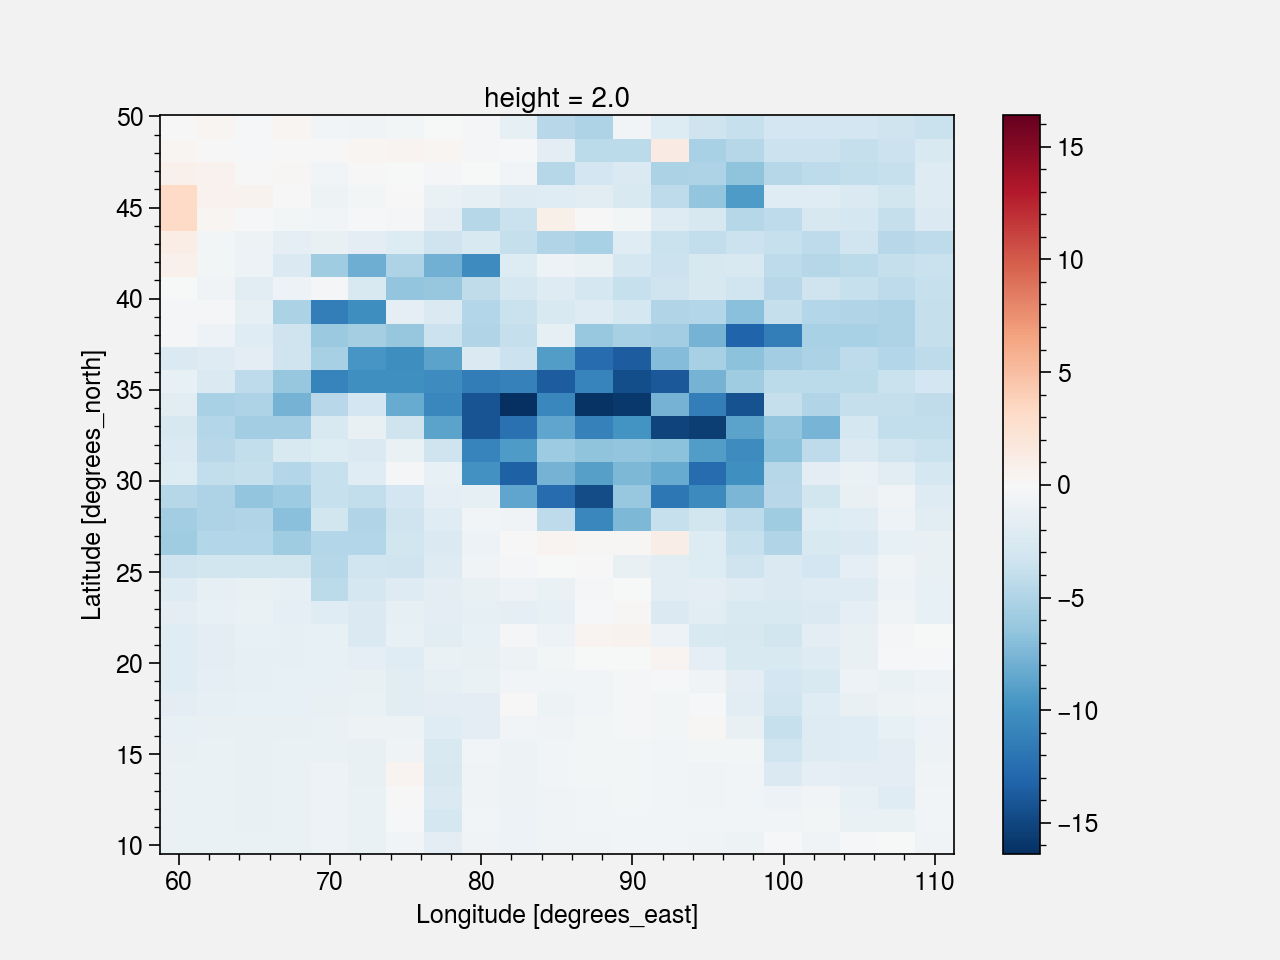

In [8]:
tas_bias.plot()

In [9]:
tas_bias.max()

<xarray.DataArray ()>
array(3.31948477)
Coordinates:
    height   float64 2.0

In [10]:
tas_bias.min()

<xarray.DataArray ()>
array(-16.39639211)
Coordinates:
    height   float64 2.0

In [14]:
tas.lon.values

array([ 60. ,  62.5,  65. ,  67.5,  70. ,  72.5,  75. ,  77.5,  80. ,
        82.5,  85. ,  87.5,  90. ,  92.5,  95. ,  97.5, 100. , 102.5,
       105. , 107.5, 110. ], dtype=float32)

In [15]:
tas.lat.values

array([10.140845, 11.408451, 12.676056, 13.943662, 15.211267, 16.478872,
       17.746479, 19.014084, 20.28169 , 21.549295, 22.816902, 24.084507,
       25.352112, 26.619719, 27.887323, 29.15493 , 30.422535, 31.690142,
       32.957745, 34.225353, 35.492958, 36.760563, 38.028168, 39.295776,
       40.56338 , 41.830986, 43.09859 , 44.366196, 45.633804, 46.90141 ,
       48.169014, 49.43662 ], dtype=float32)

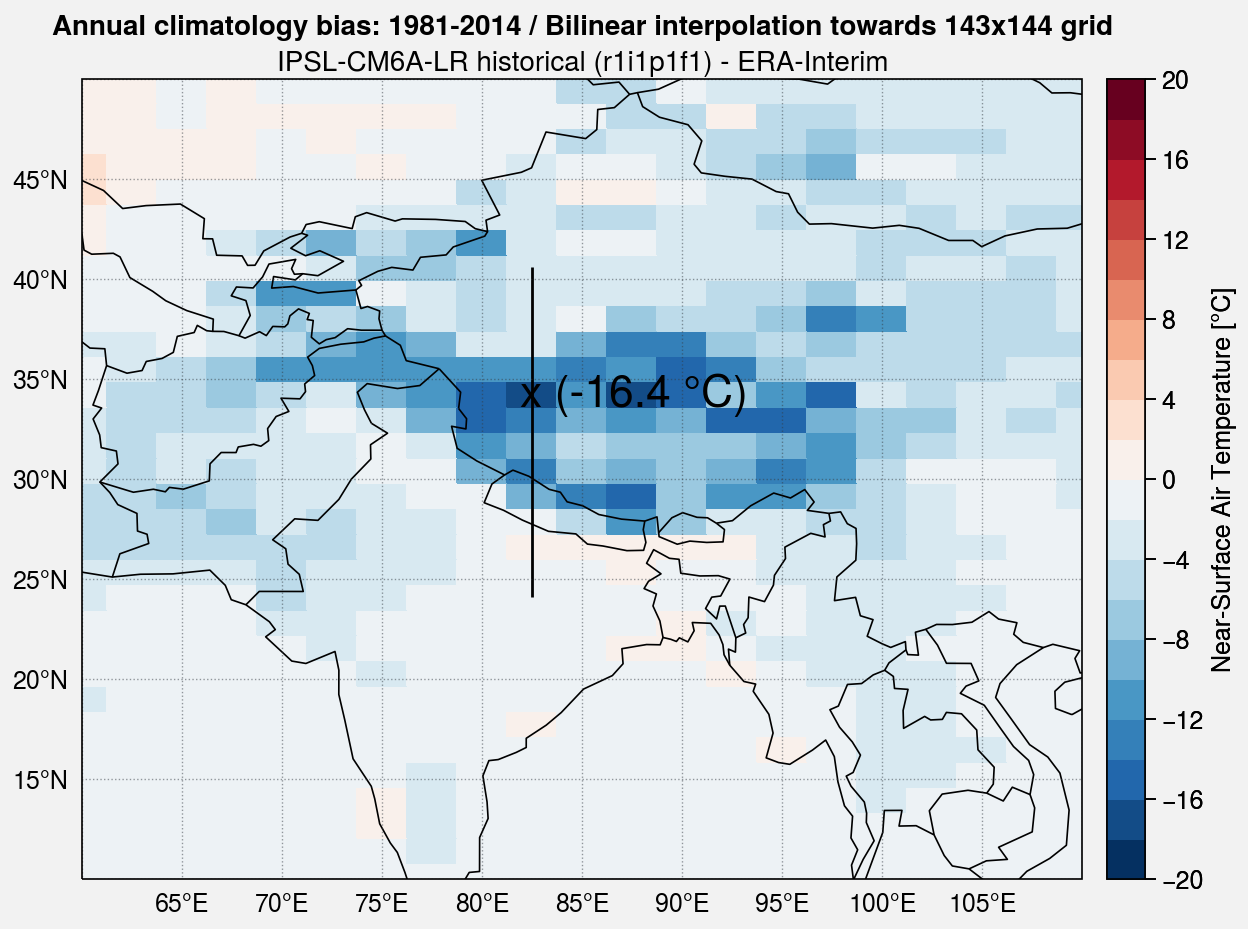

In [8]:
import matplotlib.patches as mpatches
import cartopy.crs as ccrs

dx=2.5
dy=1.2676

f, axs = plot.subplots(proj='cyl', ncols=1, nrows=1, axwidth=5)

m = axs[0].pcolormesh(tas_bias, cmap='RdBu_r', levels=plot.arange(-20,20,2))
axs[0].format(title='IPSL-CM6A-LR historical (r1i1p1f1) - ERA-Interim')

f.colorbar(m, label='Near-Surface Air Temperature [°C]')

# Add boxes
# for ax in axs:
#     u.plot_zones_IPSL_CM6A_LR(ax)
    
axs[0].add_patch(mpatches.Rectangle(
    xy=[82.5, 24.084507], width=0, height=40.56338-24.084507,
    transform=ccrs.PlateCarree(), fill=False
))
axs[0].text(82.5-dx/4, 34.225353-dy/2, 'x (-16.4 °C)', fontsize=16, 
#             horizontalalignment='center', verticalalignment='center'
           )

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Annual climatology bias: 1981-2014 / Bilinear interpolation towards 143x144 grid",
    lonlines=5, latlines=5, abc=False, latlim=latlim, lonlim=lonlim
)

# var = 'ta'
# f.save('img/'+var+'/tas_IPSL_CMIP6-ERAI_bias.png')
# f.save('img/'+var+'/tas_IPSL_CMIP6-ERAI_bias.pdf')

In [13]:
tas_bias.sel(lat=34.225353, lon=82.5)

<xarray.DataArray ()>
array(-16.39639211)
Coordinates:
    lat      float32 34.225353
    lon      float32 82.5
    height   float64 2.0

In [58]:
tas_bias.sel(lat=30.422535, lon=82.5)

<xarray.DataArray ()>
array(-13.37309474)
Coordinates:
    lat      float32 30.422535
    lon      float32 82.5
    height   float64 2.0

# Load surface pressure for masking ERA-Interim
http://clipc-services.ceda.ac.uk/dreq/u/8c9504d28596e05586c8e193082ac617.html

In [9]:
realization = 'r1i1p1f1'
var = 'ps'
table = 'Amon'

# Load historical
ps = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', 
    combine='by_coords'
).sel(time=period)[var]

# ERA-Interim
ps_era = xr.open_mfdataset(
    "/data/mlalande/ERAI/sp/sp_ERAI_*.nc",
    combine='by_coords', parallel=True
).sp.sel(time=period).load()

In [22]:
ps_era_regrid = regridder(ps_era)

ps = ps.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).load()
ps_era_regrid = ps_era_regrid.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).load()

# Get the minimum pressure (finally not used)
ps_min = ps.min('time')
ps_era_regrid_min = ps_era_regrid.min('time')

# Load Air Temperature

In [43]:
var ='ta'

ta = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords', parallel=True
).sel(time=period)[var].load()-273.15

ta_era = xr.open_mfdataset(
    '/bdd/ERAI/NETCDF/GLOBAL_075/1xmonthly/AN_PL/*/ta.*.apmei.GLOBAL_075.nc',
    combine='by_coords', parallel=True
).ta.sel(time=period).load()-273.15

## Regrid horizontal

In [44]:
# Regrid horizontal
ta_era_regrid = regridder(ta_era)

## Select zone

In [46]:
ta = ta.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).load()
ta_era_regrid = ta_era_regrid.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).load()

## Mask vertical values > ps

In [47]:
ta_era_regrid_masked = ta_era_regrid.where(ta_era_regrid.level <= ps_era_regrid/100)

## Regrid vertical

In [48]:
ta_era_regrid_masked_v = ta_era_regrid_masked.interp(level=(ta.plev.values/100), method='linear')

## Compute climatologie

In [57]:
ta_clim = ta.mean('time', skipna=False).load()
ta_era_regrid_masked_clim = ta_era_regrid_masked.mean('time', skipna=False).load()
ta_era_regrid_masked_v_clim = ta_era_regrid_masked_v.mean('time', skipna=False).load()

ta_bias = ta_clim-ta_era_regrid_masked_v_clim.values

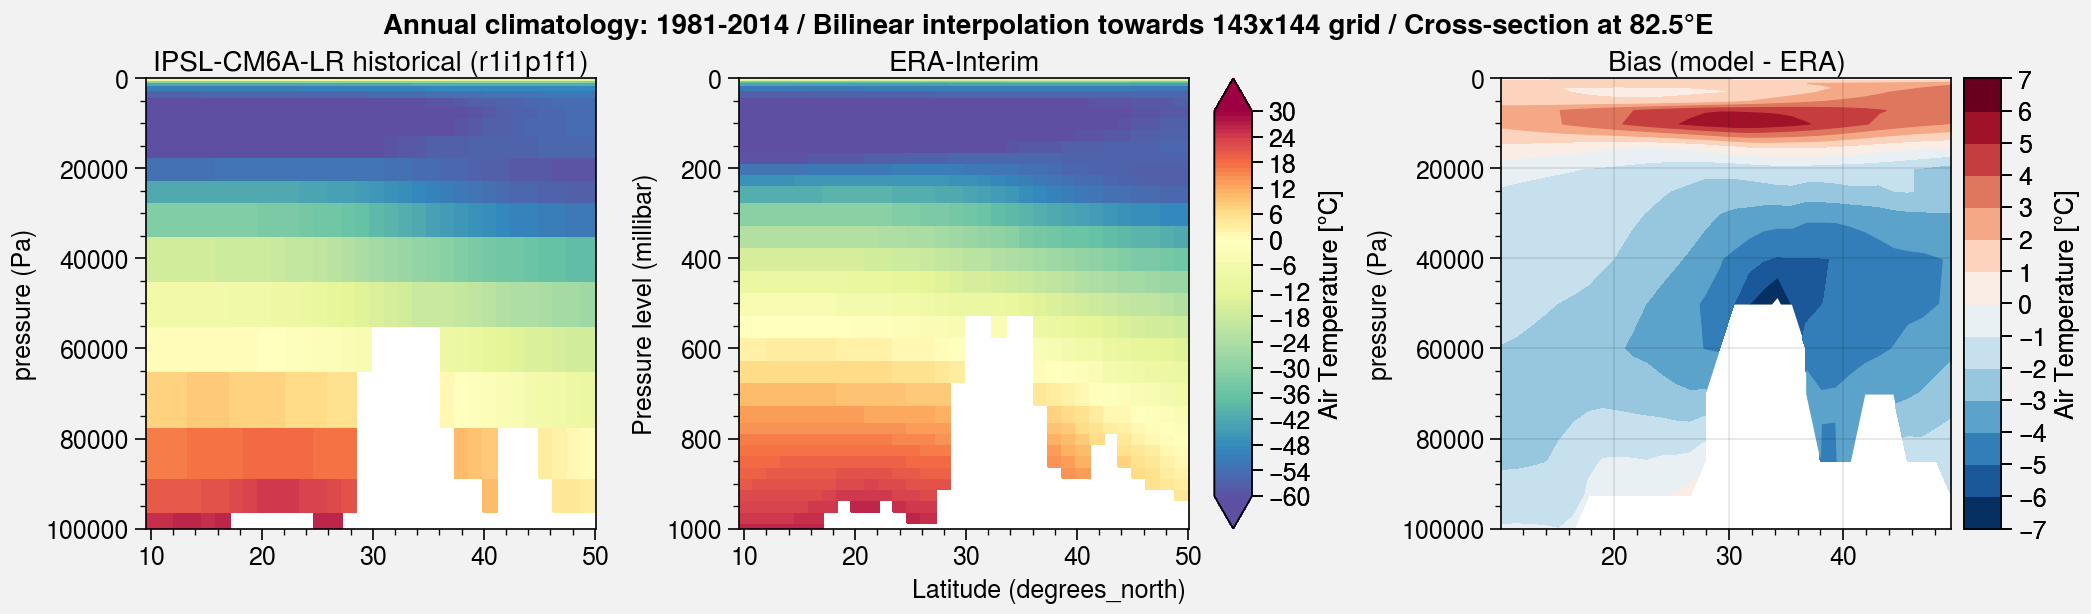

In [64]:
#Check colorbars 
levels = plot.arange(-60,30,1)
extend='both'
cmap='Spectral'

f, axs = plot.subplots(nrows=1, ncols=3, sharey=0)

# Model
m1 = axs[0].pcolormesh(ta_clim.sel(lon=82.5), cmap=cmap, levels=levels, norm='midpoint', extend=extend)
axs[0].format(ylim=(100000,0), title='IPSL-CM6A-LR historical (r1i1p1f1)')

# ERA-Interim
axs[1].pcolormesh(ta_era_regrid_masked_clim.sel(lon=82.5), cmap=cmap, levels=levels, norm='midpoint', extend=extend)
axs[1].format(ylim=(1000,0), title='ERA-Interim')
axs[1].colorbar(m1, label='Air Temperature [°C]')

# Bias
m2 = axs[2].contourf(ta_bias.sel(lon=82.5), cmap='BuRd', levels=plot.arange(-7,7,1))
axs[2].format(ylim=(100000,0), title='Bias (model - ERA)')
axs[2].colorbar(m2, label='Air Temperature [°C]')


axs.format(
    suptitle="Annual climatology: 1981-2014 / Bilinear interpolation towards 143x144 grid / Cross-section at 82.5°E"
)

# f.save('img/ta/slice_lon_82_5_ta_pcolormesh.png')
# f.save('img/ta/slice_lon_82_5_ta_pcolormesh.pdf')

In [89]:
ta_bias.lat

<xarray.DataArray 'lat' (lat: 32)>
array([10.140845, 11.408451, 12.676056, 13.943662, 15.211267, 16.478872,
       17.746479, 19.014084, 20.28169 , 21.549295, 22.816902, 24.084507,
       25.352112, 26.619719, 27.887323, 29.15493 , 30.422535, 31.690142,
       32.957745, 34.225353, 35.492958, 36.760563, 38.028168, 39.295776,
       40.56338 , 41.830986, 43.09859 , 44.366196, 45.633804, 46.90141 ,
       48.169014, 49.43662 ], dtype=float32)
Coordinates:
  * lat      (lat) float32 10.140845 11.408451 12.676056 ... 48.169014 49.43662
Attributes:
    axis:           Y
    standard_name:  latitude
    long_name:      Latitude
    units:          degrees_north

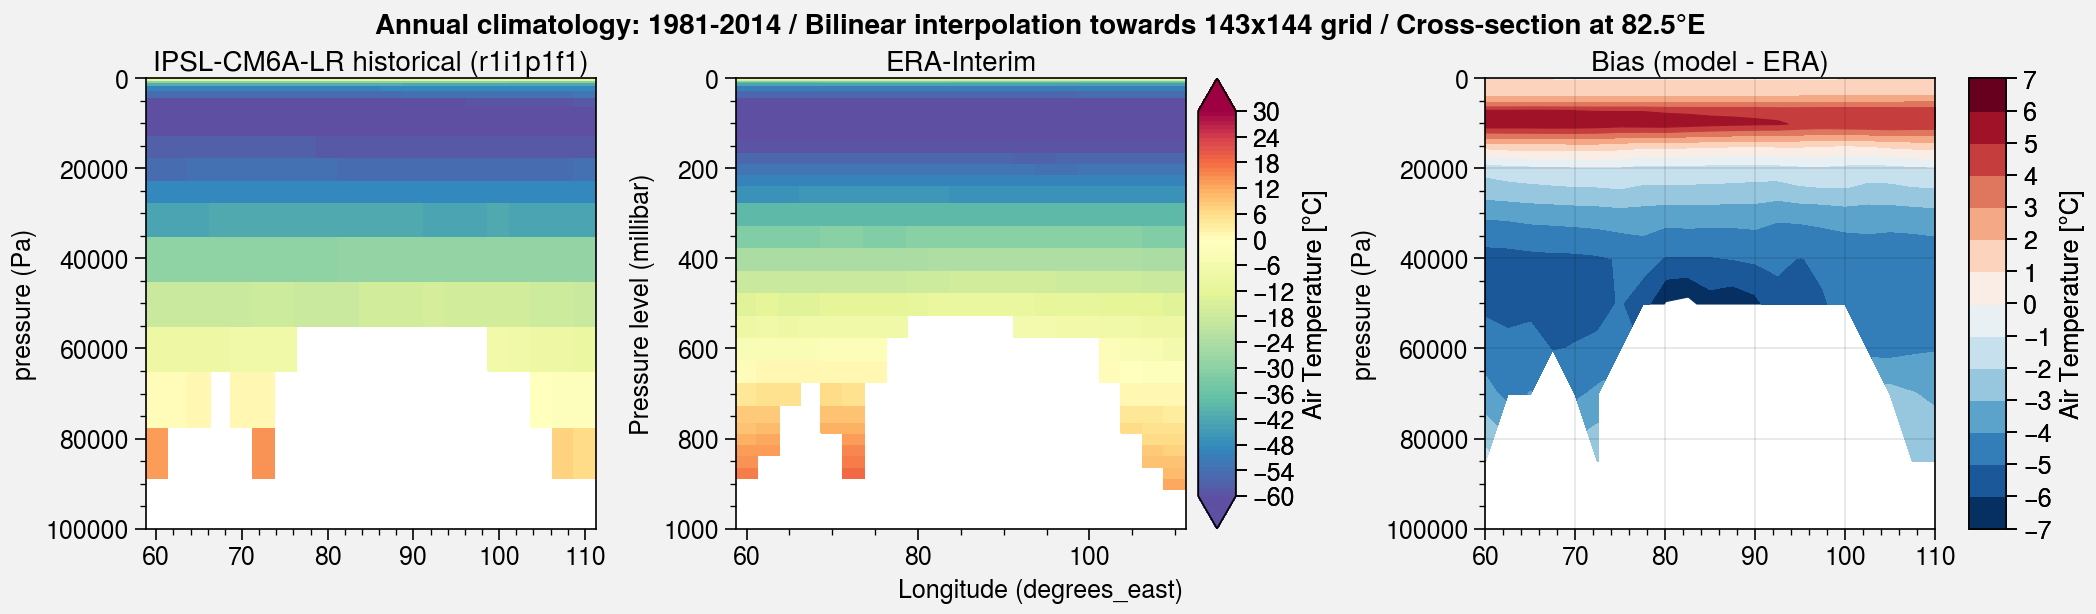

In [90]:
#Check colorbars 
levels = plot.arange(-60,30,1)
extend='both'
cmap='Spectral'

f, axs = plot.subplots(nrows=1, ncols=3, sharey=0)

# Model
m1 = axs[0].pcolormesh(ta_clim.sel(lat=34.225353), cmap=cmap, levels=levels, norm='midpoint', extend=extend)
axs[0].format(ylim=(100000,0), title='IPSL-CM6A-LR historical (r1i1p1f1)')

# ERA-Interim
axs[1].pcolormesh(ta_era_regrid_masked_clim.sel(lat=34.225353), cmap=cmap, levels=levels, norm='midpoint', extend=extend)
axs[1].format(ylim=(1000,0), title='ERA-Interim')
axs[1].colorbar(m1, label='Air Temperature [°C]')

# Bias
m2 = axs[2].contourf(ta_bias.sel(lat=34.225353), cmap='BuRd', levels=plot.arange(-7,7,1))
axs[2].format(ylim=(100000,0), title='Bias (model - ERA)')
axs[2].colorbar(m2, label='Air Temperature [°C]')


axs.format(
    suptitle="Annual climatology: 1981-2014 / Bilinear interpolation towards 143x144 grid / Cross-section at 34°N"
)

# f.save('img/ta/slice_lon_82_5_ta_pcolormesh.png')
# f.save('img/ta/slice_lon_82_5_ta_pcolormesh.pdf')

## Differences

In [73]:
ta_bias.max()

<xarray.DataArray 'ta' ()>
array(6.11707188)

In [74]:
ta_bias.min()

<xarray.DataArray 'ta' ()>
array(-7.34939633)

In [82]:
str(ta_bias.isel(lon=0).lon.values)

'60.0'

In [84]:
21/4

5.25

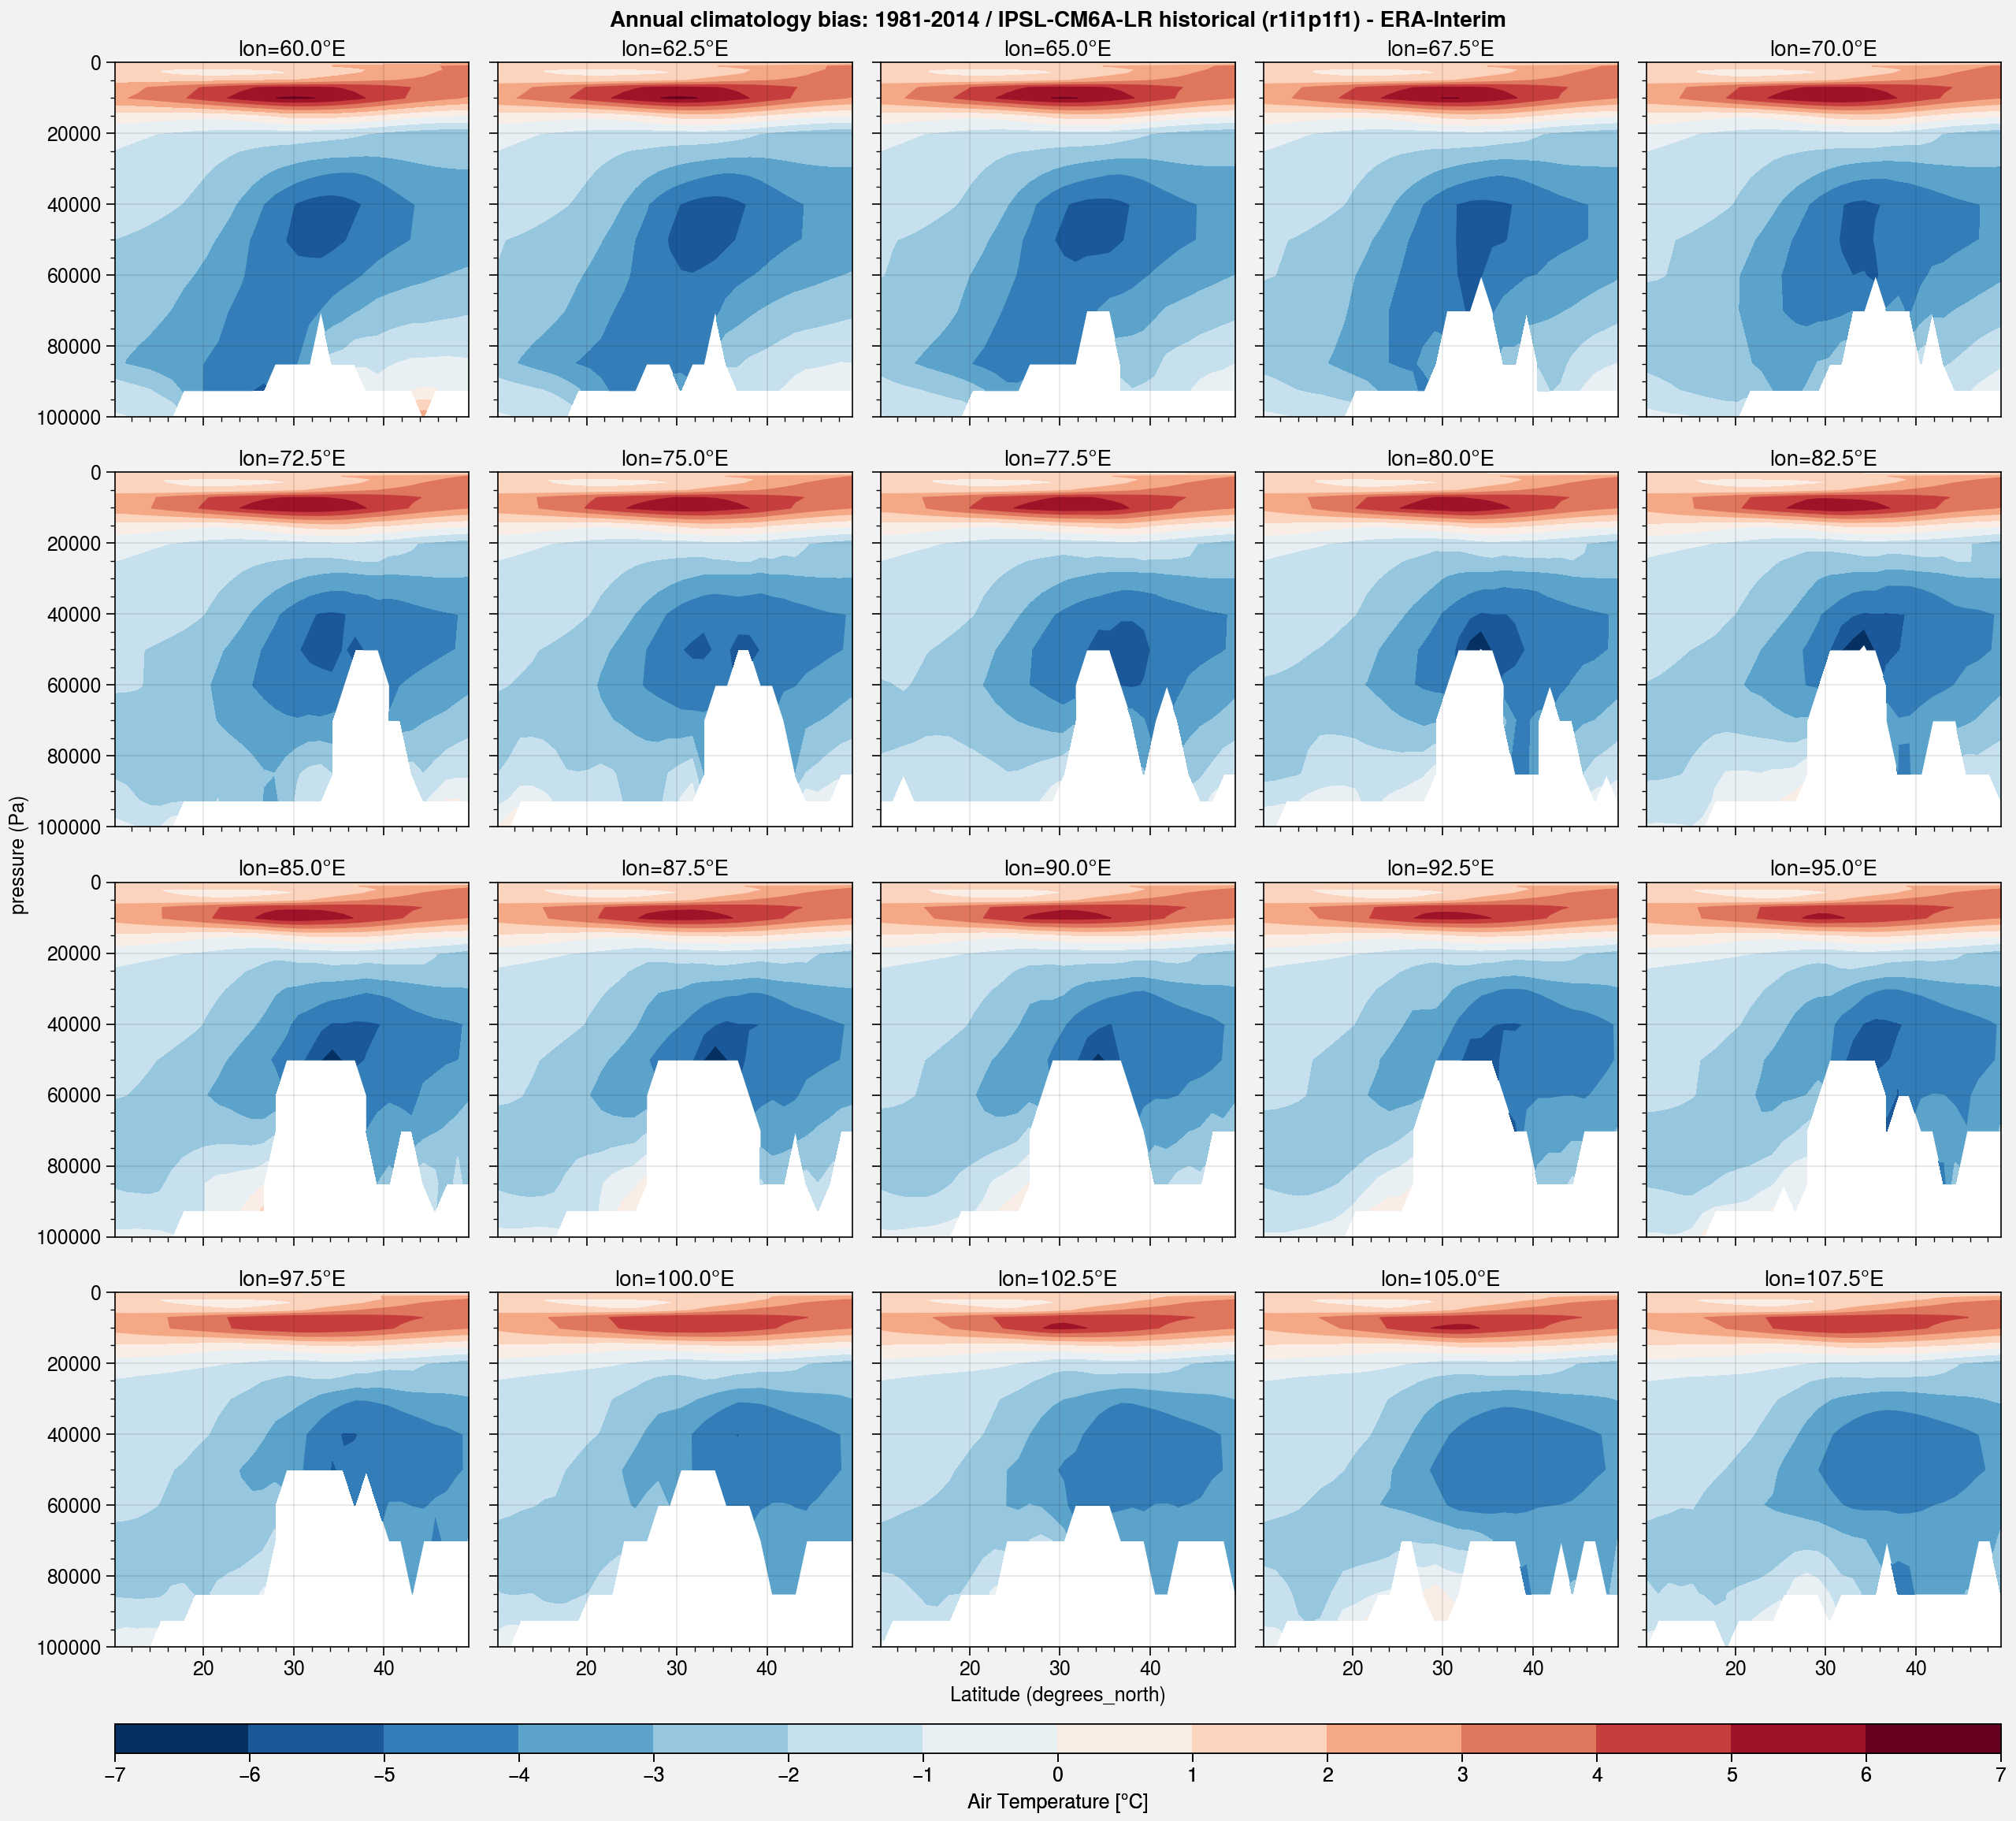

In [88]:
#Check colorbars 
levels = plot.arange(-60,30,1)
extend='both'
cmap='Spectral'

f, axs = plot.subplots(nrows=4, ncols=5)

for i, ax in enumerate(axs):
    m = ax.contourf(ta_bias.isel(lon=i), cmap='BuRd', levels=plot.arange(-7,7,1))
    ax.format(ylim=(100000,0), title='lon='+str(ta_bias.isel(lon=i).lon.values)+'°E')

f.colorbar(m2, label='Air Temperature [°C]', loc='b')


axs.format(
    suptitle="Annual climatology bias: 1981-2014 / IPSL-CM6A-LR historical (r1i1p1f1) - ERA-Interim"
)

# f.save('img/ta/slice_lon_82_5_ta_pcolormesh.png')
# f.save('img/ta/slice_lon_82_5_ta_pcolormesh.pdf')